# Analysis of TDA Methods

In [33]:
%load_ext autoreload
%autoreload 2
%cd '../src'
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/media/apfriend/sabrent/ucsd/classes/dsc190/project/src


In [34]:
import os
import sys
import re
import warnings
import gudhi as gd
import pandas as pd
import numpy as np
import nglview as nv
from Bio.PDB import PDBParser
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import eda as eda
import pda as pda

#hide discontinuous chain warnings
warnings.simplefilter('ignore', PDBConstructionWarning)

In [36]:
src='../data/out/birth_death_data.csv'
persistence_df=pd.read_csv(src)
persistence_df['extra_features']=persistence_df.betti_0-persistence_df.num_chains
persistence_df

,protein_tag,num_atoms,num_chains,betti_0,betti_1,max_radius,num_vertices,num_simplices,extra_features
0,1pid,810,4,52,41,3,810,4974,48
1,1pid,810,4,29,52,4,810,13066,25
2,1pid,810,4,20,5,5,810,38709,16
3,1pid,810,4,14,7,6,810,94977,10
4,1pid,810,4,10,1,7,810,190048,6
...,...,...,...,...,...,...,...,...,...
91,3cji,6521,4,2,1,6,6521,1053126,-2
92,3cji,6521,4,1,1,7,6521,2402964,-3
93,3cji,6521,4,1,0,8,6521,4829760,-3
94,3cji,6521,4,1,0,9,6521,9085935,-3


In [37]:
persistence_df.describe()

,num_atoms,num_chains,betti_0,betti_1,max_radius,num_vertices,num_simplices,extra_features
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,9.600000e+01,96.000000
mean,6465.083333,6.416667,5.135417,156.687500,6.500000,6465.083333,4.492919e+06,-1.281250
std,8505.158058,6.736650,11.519887,476.434594,2.303316,8505.158058,9.965260e+06,14.099424
min,722.000000,1.000000,1.000000,0.000000,3.000000,722.000000,4.974000e+03,-21.000000
25%,1077.250000,2.000000,1.000000,0.000000,4.750000,1077.250000,1.270170e+05,-3.000000
50%,2613.500000,4.000000,1.000000,2.000000,6.500000,2613.500000,7.238010e+05,-1.000000
75%,6526.000000,6.000000,1.250000,54.500000,8.250000,6526.000000,3.483289e+06,0.000000
max,25909.000000,22.000000,58.000000,3012.000000,10.000000,25909.000000,5.415554e+07,54.000000


## Compare features of difference persistence modules
### Plot extra features by max radius

In [38]:
from glob import glob

files=glob('../data/test/csv-data/*/*')
file_group=[os.path.basename(os.path.dirname(file)) for file in files]
tag=[os.path.basename(file).replace('.csv','') for file in files]
tag_lookup=dict(zip(tag, file_group))
tag_lookup

{'1pid': 'Bovine-Insulin',
 '2rmu': 'Common-Cold',
 '1trz': 'Designer-Insulins',
 '4ajx': 'Designer-Insulins',
 '4iyf': 'Designer-Insulins',
 '1H2C': 'Ebola',
 '3IOL': 'Glucagon',
 '1IR3': 'Insulin-Receptor',
 '1IRK': 'Insulin-Receptor',
 '6VXX': 'Sars-Cov-2-Spike',
 '6crz': 'Sars-Cov-Spike',
 '3cji': 'Seneca-Valley-Virus'}

In [39]:
persistence_df['protein_name']=persistence_df.protein_tag.apply(lambda x: tag_lookup[x])
persistence_df

,protein_tag,num_atoms,num_chains,betti_0,betti_1,max_radius,num_vertices,num_simplices,extra_features,protein_name
0,1pid,810,4,52,41,3,810,4974,48,Bovine-Insulin
1,1pid,810,4,29,52,4,810,13066,25,Bovine-Insulin
2,1pid,810,4,20,5,5,810,38709,16,Bovine-Insulin
3,1pid,810,4,14,7,6,810,94977,10,Bovine-Insulin
4,1pid,810,4,10,1,7,810,190048,6,Bovine-Insulin
...,...,...,...,...,...,...,...,...,...,...
91,3cji,6521,4,2,1,6,6521,1053126,-2,Seneca-Valley-Virus
92,3cji,6521,4,1,1,7,6521,2402964,-3,Seneca-Valley-Virus
93,3cji,6521,4,1,0,8,6521,4829760,-3,Seneca-Valley-Virus
94,3cji,6521,4,1,0,9,6521,9085935,-3,Seneca-Valley-Virus


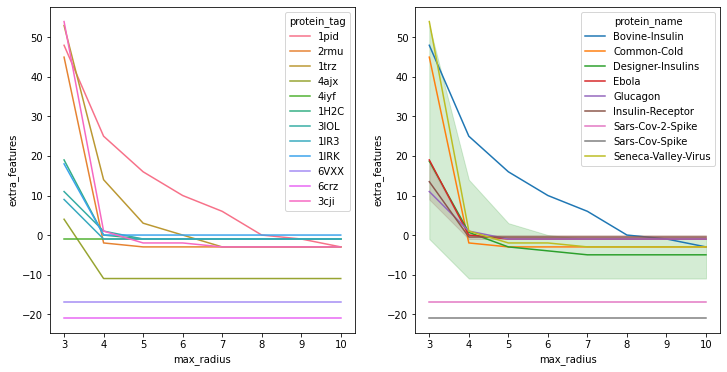

In [40]:
eda.plot_feature_accuracy_by_radius(persistence_df)

It appears as though a radios of 4 is ideal for most proteins for accurately extracting connected components, i.e. protein chains.

### Comparison of number of simplices and features

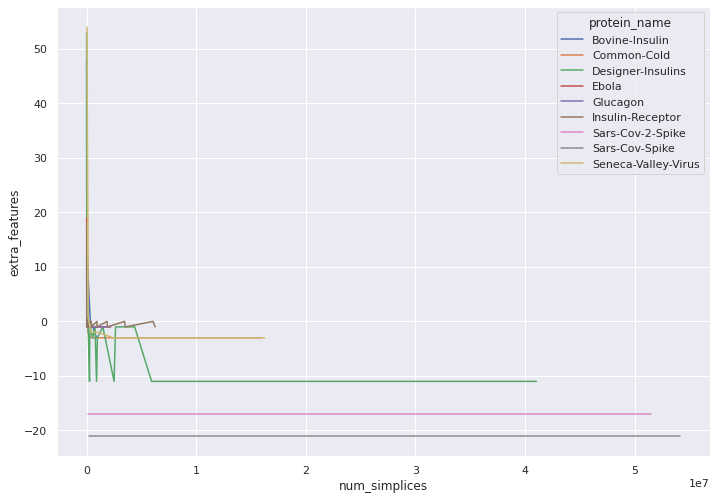

In [47]:
sns.lineplot(
    data=persistence_df,
    x='num_simplices',
    y='extra_features',
    hue='protein_name'
)
sns.set(rc={'figure.figsize':(8,6)})
plt.show()

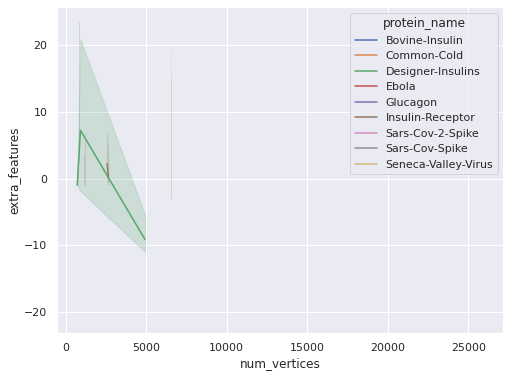

In [48]:
sns.lineplot(
    data=persistence_df,
    x='num_vertices',
    y='extra_features',
    hue='protein_name'
)
sns.set(rc={'figure.figsize':(8,6)})
plt.show()

In [15]:
max_radius=4
rinsulin_csv_fp='../data/test/csv-data/Designer-Insulins/1trz.csv'
rinsulin_pdb_fp='../data/test/pdb-data/Designer-Insulins/1trz.pdb'

parser=PDBParser()
rinsulin_structure=parser.get_structure('1trz', rinsulin_pdb_fp)
nv.show_biopython(rinsulin_structure)

NGLWidget()

In [24]:
rinsulin_point_data=pd.read_csv(rinsulin_csv_fp).loc[:,['atom_coord_x','atom_coord_y','atom_coord_z']].values
rinsulin_rips=pda.rips_complex(rinsulin_point_data, max_radius)
rinsulin_simplex_tree=rinsulin_rips.create_simplex_tree()
# for filtration in rinsulin_simplex_tree.get_filtration():
#     print(filtration)
rinsulin_simplex_tree.dimension()

1

In [ ]:
Protein binding dataset

The data we study in this notebook pertains to configurations of protein binding. This example is borrowed from the paper of Kovacev-Nikolic et al. [1].

The paper compares closed and open forms of the maltose-binding protein (MBP), a large biomolecule containing 370
amino-acid residues. The analysis is not based on geometric distances in ℝ3 but on a metric of dynamical distances defined by